<a name="outline"></a>

## Outline

- [Section 1](#section-1): Intro to kNN
- [Section 2](#section-2): Classification with kNN
- [Section 3](#section-3): Hyperparameter Tuning for $k$ with _T-fold_ Cross Validation
- [Section 4](#section-4): Regression with kNN


# _k_ nearest neighbours (kNN) 

The purpose of this notebook is to understand and implement the kNN algorithm without making use of sklearn

<a name="section-1"></a>

## Section 1: Intro to kNN [^](#outline)

The k-Nearest Neighbors (kNN) algorithm is a versatile machine learning algorithm that can be used for both classification and regression tasks. Its main idea is to find the k closest data points to a given point "x" in the dataset based on some distance metric. For classification, kNN assigns the new point "x" to the majority class among its k nearest neighbors. For instance, if we have k=3 closest points to "x," and two of them are labeled as "red" while one is labeled as "blue," the algorithm would classify "x" as "red."

On the other hand, for regression tasks, the labels are considered continuous variables. In this case, kNN assigns the label of data point "x" as the mean value of the labels of its k nearest neighbors. Instead of majority voting, kNN takes the average of the target variable values to make predictions for "x."

The kNN algorithm's simplicity and flexibility make it a popular choice for various machine learning tasks, and its behavior can be easily adjusted based on the value of k. However, it is essential to consider the appropriate value of k, as a small k value may lead to overfitting, while a large k value may lead to oversmoothing and loss of detail in the predictions.

In [1]:
import numpy as np
from sklearn.datasets import make_classification, fetch_california_housing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

we must start with defining a function that computes such a distance. For simplicity, we will only work with **Euclidean distances** in this notebook, but other distances can be chosen interchangably, of course.

Implement in the following cell the Euclidean distance $d$, defined as
$$
d(\boldsymbol p, \boldsymbol q) = \sqrt{\sum_{i=1}^D{(q_i-p_i)^2}} \, ,
$$
where $\boldsymbol p$ and $\boldsymbol q$ are the two points in our $D$-dimensional Euclidean space.


In [2]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1)) 

<a name="section-2"></a>

## Section 2: Classification with kNN [^](#outline)

We start with using kNN for classification tasks, and create a dataset with sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function and standardise the data.

In [3]:
X_class, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3, random_state=15)

In [4]:

def standardise(X):
  mu = np.mean(X, 0)
  sigma = np.std(X, 0)
  X_std = (X - mu) / sigma 
  return X_std

In [5]:
X = standardise(X_class)

As with any other supervised machine learning method, we create a training and test set to learn and evaluate our model, respectively.

In [6]:
# shuffling the rows in X and y
p = np.random.permutation(len(y))
X = X[p]
y = y[p]

# we split train to test as 70:30
split_rate = 0.7
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

We visualise the data set with points in the training set being fully coloured and points in the test being half-transparent.

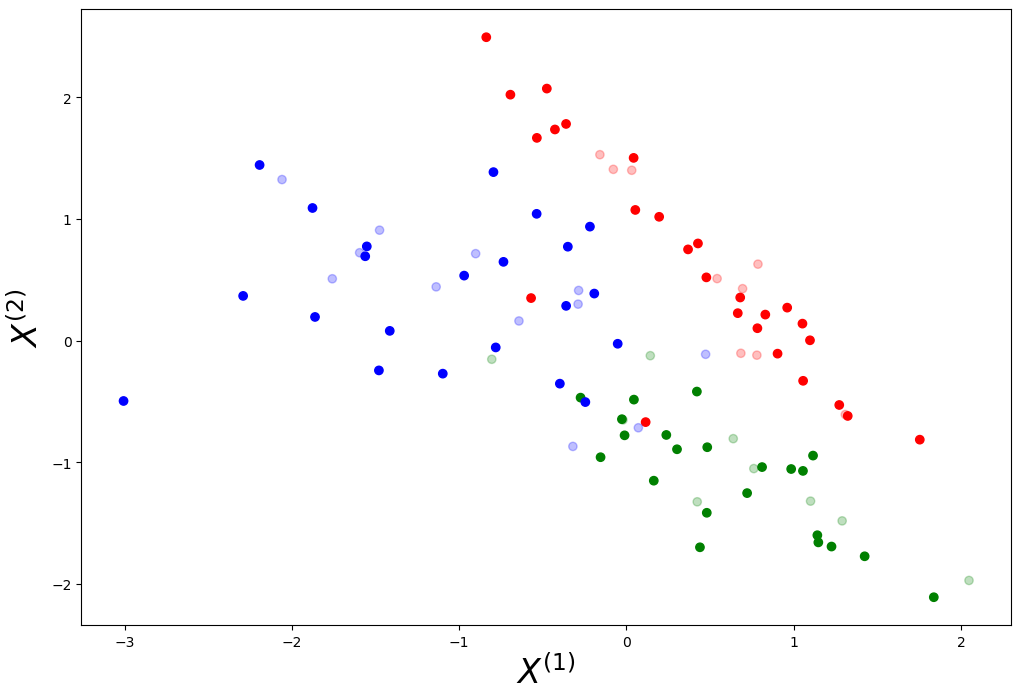

In [7]:
# define colormaps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['blue', 'red', 'green'])

# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r'$X^{(1)}$', size=24)
plt.ylabel(r'$X^{(2)}$', size=24)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.25)
plt.show()

We try to find the _k_ nearest neighbours in our training set for every test data point. The majority of labels of the _k_ closest training points determines the label of the test point. 

In [8]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
  n_neighbours = k
  dist = []
  neigh_ind = []
  
  # compute distance from each point x_test in X_test to all points in X_train
  point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)
  
  # return distances together with indices of k nearest neighbours
  if return_distance:
      return np.array(dist), np.array(neigh_ind)
  
  return np.array(neigh_ind)

Once we know which _k_ neighbours are closest to our test points, we can predict the labels of these test points.

we call the previous function `k_neighbours` _within_ the next function `predict`.

Our `predict` function determines how any point $x_\text{test}$ in the test set is classified. Here, we only consider the case where each of the *k* neighbours contributes equally to the classification of $x_\text{test}$.

In [9]:
def predict(X_train, y_train, X_test, k=5):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_train, X_test, k=k)
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

  return y_pred

To evaluate the algorithm in a more principled way, we need to implement a function that computes the mean accuracy by counting how many of the test points have been classified correctly and dividing this number by the total number of data points in our test set.

Again, we do this is in a pythonic way and call the previous `predict` function _within_ the next function `score`.

In [10]:
def score(X_train, y_train, X_test, y_test, k=5):
  y_pred = predict(X_train, y_train, X_test, k=k)
  return np.float(sum(y_pred==y_test))/ float(len(y_test))

It is quite common to print both the training and test set accuracies.

In [11]:
k = 8
print('Training set mean accuracy:', score(X_train, y_train, X_train, y_train, k=k))
print('Test set mean accuracy:', score(X_train, y_train, X_test, y_test, k=k))

Training set mean accuracy: 0.9571428571428572
Test set mean accuracy: 0.8666666666666667


C:\Users\44746\AppData\Local\Temp\ipykernel_8256\738026063.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(sum(y_pred==y_test))/ float(len(y_test))


we consider a ratio 80:20 for training and test splits

In [12]:
# shuffling the rows in X and y
p = np.random.permutation(len(y))
X = X[p]
y = y[p]


# we split train to test as 80:20
split_rate = 0.8
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

Now let's partition our training split into 5-folds. We could store the corresponding indices only:

In [13]:
# Now we have a list of five index arrays, each correspond to one of the five folds.
folds_indexes = np.split(np.arange(len(y_train)), 5)
folds_indexes

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])]

Let's implement a function that evalutes the accuracy of model with a given $k$ by running $T$ experiments and returning the average evaluated accuracy.

In [14]:
def cross_validation_score(X_train, y_train, folds, k):
  scores = []
  for i in range(len(folds)):
    val_indexes = folds[i]
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]


    X_val_i = X_train[val_indexes, :] 
    y_val_i = y_train[val_indexes] 

    score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
    scores.append(score_i)

  # Return the average score
  return sum(scores) / len(scores) 

Let's scan a range of $k$ in $[1, 30]$ and select the one with the best cross-validation accuracy.

In [15]:
def choose_best_k(X_train, y_train, folds, k_range):
  k_scores = np.zeros((len(k_range),))
  
  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
    print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

  best_k_index = np.argmax(k_scores)
  return k_range[best_k_index]


In [16]:
best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1, 31))

print('best_k:', best_k)

CV_ACC@k=1: 0.812
CV_ACC@k=2: 0.825
CV_ACC@k=3: 0.850
CV_ACC@k=4: 0.875
CV_ACC@k=5: 0.850
CV_ACC@k=6: 0.887
CV_ACC@k=7: 0.850
CV_ACC@k=8: 0.863
CV_ACC@k=9: 0.850
CV_ACC@k=10: 0.850
CV_ACC@k=11: 0.825
CV_ACC@k=12: 0.863
CV_ACC@k=13: 0.863
CV_ACC@k=14: 0.838
CV_ACC@k=15: 0.838
CV_ACC@k=16: 0.838
CV_ACC@k=17: 0.812
CV_ACC@k=18: 0.812
CV_ACC@k=19: 0.812
CV_ACC@k=20: 0.800
CV_ACC@k=21: 0.800
CV_ACC@k=22: 0.812
CV_ACC@k=23: 0.812
CV_ACC@k=24: 0.787
CV_ACC@k=25: 0.800
CV_ACC@k=26: 0.762
CV_ACC@k=27: 0.775
CV_ACC@k=28: 0.762
CV_ACC@k=29: 0.762
CV_ACC@k=30: 0.750
best_k: 6


C:\Users\44746\AppData\Local\Temp\ipykernel_8256\738026063.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(sum(y_pred==y_test))/ float(len(y_test))


Finally, let's evaluate the accuracy with the best k on on the unseen part, the test-split that we isolated earlier.

In [17]:
score(X_train, y_train, X_test, y_test, k=best_k)

C:\Users\44746\AppData\Local\Temp\ipykernel_8256\738026063.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(sum(y_pred==y_test))/ float(len(y_test))


0.95


<a name="section-4"></a>

## Section 4:  Regression with kNN [^](#outline)

The kNN algorithm is mostly used for classification, but we can also utilise it for (non-linear) regression. Here, we calculate the label of every point in the test set as the mean of the _k_ nearest neighbours.

We start with defining a training set with sklearn's California housing data set. Note that this data set has normally 8 features, but we only extract the first feature, which corresponds to the median income in the district. The label is the median house value in the district.


In [18]:
data = fetch_california_housing(return_X_y=True)
X = data[0][:,0].reshape((-1, 1))
y = data[1]

X_std = standardise(X)

As before, we first divide the data into training and test set:

In [19]:
# shuffling the rows in X and y
p = np.random.permutation(len(y))
X = X_std[p]
y = y[p]

# we split train to test as 70:30
split_rate = 0.7
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

Let's plot it to get a sense how we can proceed. This time, we plot training examples in blue and test examples in red.

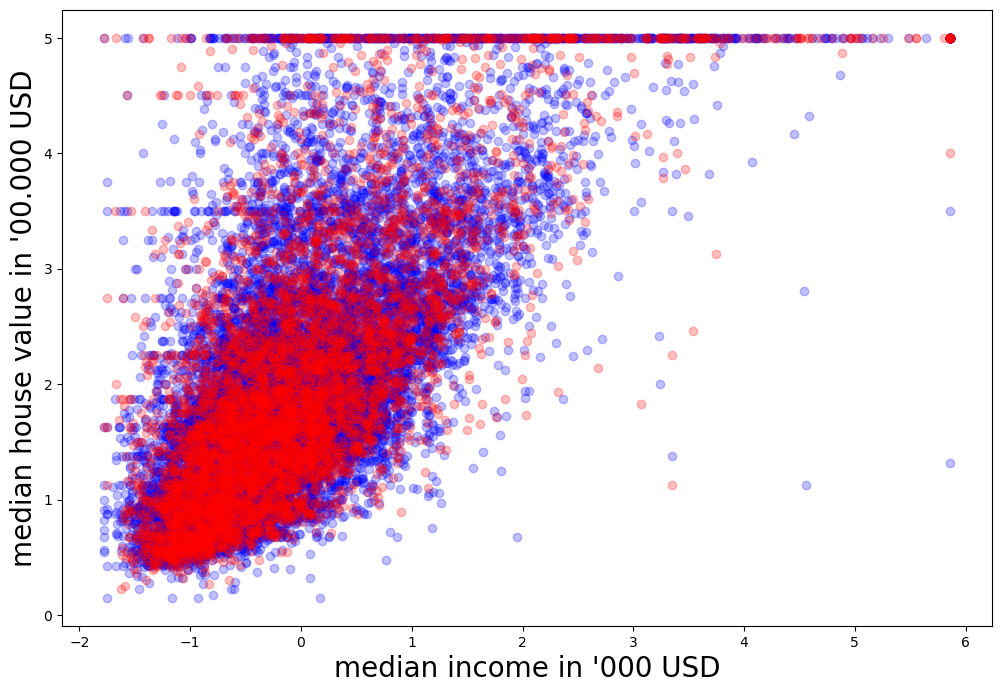

In [20]:
# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r"median income in '000 USD", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.show()

As before, we need to define a predicting function which we call `reg_predict`.

In [21]:

def reg_predict(X_train, y_train, X_test, k=20):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_train, X_test, k=k)
  # compute mean over neighbours labels 
  y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours]) 

  return y_pred

In [22]:
# computing predictions
k = 20
y_pred = reg_predict(X_train, y_train, X_test, k=k)

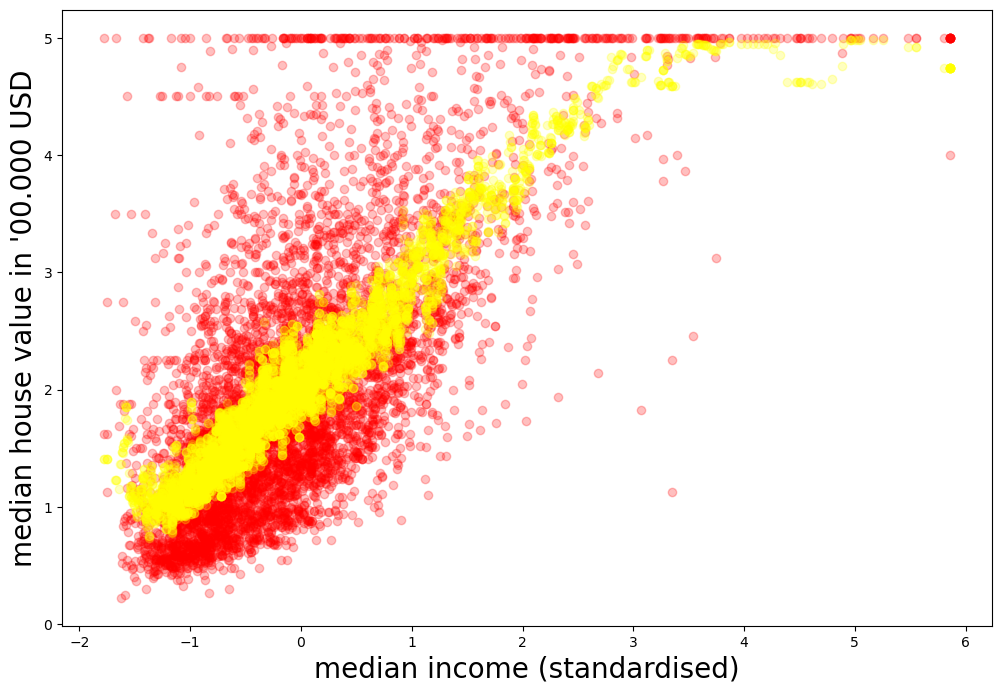

In [23]:
# ... and plotting them
plt.figure(figsize=(12,8))
plt.xlabel(r"median income (standardised)", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
#plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', alpha=0.25)
plt.show()

To determine how well the prediction was, let us determine the $R^2$ score. The labels of the test set will be called $y$ and the predictions on the test data $\hat{y}$.
$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2} \, ,
$$
where $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$.

In [24]:
def r2_score(y_test, y_pred):
  numerator = np.sum((y_test - y_pred)**2) 
  y_avg = np.mean(y_test) 
  denominator = np.sum((y_test - y_avg)**2)
  return 1 - numerator/denominator 

In [25]:
print(r'R2 score:', r2_score(y_test, y_pred))

R2 score: 0.47142533436345213
